In [53]:
import torch # version 2.1.2
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
from resnet_model import YoloV1_Pretrained
from dataset import DroneDataset
from loss import YoloLoss
from utils import *

seed = 3301 #pseudorandom seed, gets the same dataset loading
torch.manual_seed(seed)

torch.autograd.set_detect_anomaly(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

Using device cuda


In [11]:
# Hyperparameters for our model
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 50
WEIGHT_DECAY = 0    # no regularization in order for fast training
EPOCHS = 50

# Other variables for training
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FNAME = "overfit.pth.tar"
SAVE_MODEL_FNAME = "yolotrained.tar"
IMG_DIR = "data/matthew_imgs"
LABEL_DIR = "data/matthew_labels"

# Creating the Datasets

In [12]:
# This cell generates a validation set
import numpy as np
np.random.seed(3301)

In [36]:
# This cell creates the 3 datasets: train_trimmed, validation, and test

transform = transforms.Compose([
    transforms.Resize((448, 448)), 
    transforms.ToTensor()
    ])

# creating datasets/dataloaders

train_trimmed_dataset = DroneDataset(
    csv_file = 'data/10matthew.csv',
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

train_trimmed_loader = DataLoader(
    dataset = train_trimmed_dataset,
    batch_size = 1,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = False       # True for training, and since numDatapoints > batchSize
)

In [37]:
# This cell defines a function to train the model on the all the datapoints in the train_loader
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE) 
        # x has shape torch.Size([batchSize, 3, 448, 448])
        # y has shape torch.Size([batchSize, 7, 7, 30])
        
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
    
    total_loss = sum(mean_loss)/len(mean_loss)
    return total_loss

def yololoss_validation_evaluation(loader, model, loss_fn):
    """Given a dataset, evaluates the model's defined yolo loss on that dataset and returns it"""
    mean_loss = []
    
    model.eval()
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE) 
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
    model.train() # return the model in training mode
    
    total_loss = sum(mean_loss)/len(mean_loss)
    return total_loss


# Training Loop on VOC Dataset (Transfer Learning / Fine-tuning)

In [38]:
# TRAINING THE MODEL (takes 7 minutes per epoch)
model = YoloV1_Pretrained(S = 7, B = 2, C = 20).to(DEVICE)
model = DataParallel(model)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss()

# if False:
#     load_checkpoint(torch.load(LOAD_MODEL_FNAME), model, optimizer)

# performance tracking
mAP_train_list = []
mAP_valid_list = []
avgloss_train_list = []
avgloss_valid_list = []
best_valid_mAP = 0.5

# trains through the entire dataset once
model.train()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} Results:")
    # get_bboxes puts the model in .eval() mode to evaluate and then switches it back to model.train() when finished evaluating bboxes
    pred_boxes_train, target_boxes_train = get_bboxes(train_trimmed_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    # pred_boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    # target_boxes = ^
    # note: the length of these lists >= numDatapoints
    
    # Calculate the mAP from our evaluated bboxes
    mAP_train = mean_average_precision(pred_boxes_train, target_boxes_train, iou_threshold=0.5, box_format="midpoint")
    # mAP_valid = mean_average_precision(pred_boxes_valid, target_boxes_valid, iou_threshold=0.5, box_format="midpoint")
    mAP_train_list.append(mAP_train)
    # mAP_valid_list.append(mAP_valid)
    print(f"Train mAP: {mAP_train}")
    # print(f"Validation mAP: {mAP_valid}")
    
    # Calculate the average YOLO loss from our evaluated bboxes
    yolo_loss_train = train_fn(train_trimmed_loader, model, optimizer, loss_fn)
    # yolo_loss_valid = yololoss_validation_evaluation(validation_loader, model, loss_fn)
    print(f"Average training loss per image: {yolo_loss_train}")
    # print(f"Average validation loss per image: {yolo_loss_valid}")
    avgloss_train_list.append(yolo_loss_train)
    # avgloss_valid_list.append(yolo_loss_valid)
    print()

    # # early stopping - once validation mAP hits .5, we start saving the model with the best validation mAP
    # if mAP_valid > best_valid_mAP:
    #     best_valid_mAP = mAP_valid
    #     torch.save(model, "yolotrained.tar")

checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
# save_checkpoint(checkpoint, filename=SAVE_MODEL_FNAME) # saves the model with torch.save

Epoch 1 Results:
Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 11.26it/s, loss=55.7]

Average training loss per image: 50.753008948432075

Epoch 2 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 11.75it/s, loss=23.8]

Average training loss per image: 29.797447628445095

Epoch 3 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.54it/s, loss=8.3] 

Average training loss per image: 15.355530209011501

Epoch 4 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.50it/s, loss=4.79]

Average training loss per image: 5.742980188793606

Epoch 5 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.50it/s, loss=5.15]

Average training loss per image: 4.905949857499865

Epoch 6 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 13.25it/s, loss=3.25]

Average training loss per image: 4.086653656429714

Epoch 7 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 13.13it/s, loss=2.89]

Average training loss per image: 3.475035217073229

Epoch 8 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.67it/s, loss=2.06]

Average training loss per image: 3.1099461449517145

Epoch 9 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.89it/s, loss=2.86]

Average training loss per image: 2.4734978675842285

Epoch 10 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.22it/s, loss=2.3] 

Average training loss per image: 2.1703406704796686

Epoch 11 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.74it/s, loss=1.9] 

Average training loss per image: 1.9201656315061781

Epoch 12 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 13.21it/s, loss=1.79]

Average training loss per image: 1.9069502353668213

Epoch 13 Results:


Train mAP: 0.11111104488372803


100%|██████████| 9/9 [00:00<00:00, 13.24it/s, loss=1.51]

Average training loss per image: 1.7754098441865709

Epoch 14 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.05it/s, loss=1.63]

Average training loss per image: 1.7647884951697455

Epoch 15 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.86it/s, loss=1.59]

Average training loss per image: 1.8868165413538616

Epoch 16 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.75it/s, loss=2.17] 

Average training loss per image: 1.551432450612386

Epoch 17 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.77it/s, loss=2.41]

Average training loss per image: 1.747811171743605

Epoch 18 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 13.11it/s, loss=1.66]

Average training loss per image: 1.8514604833390977

Epoch 19 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.27it/s, loss=0.8] 

Average training loss per image: 1.272277553876241

Epoch 20 Results:


Train mAP: 0.22222205996513367


100%|██████████| 9/9 [00:00<00:00, 12.41it/s, loss=2.41] 

Average training loss per image: 1.2896324396133423

Epoch 21 Results:


Train mAP: 0.11111104488372803


100%|██████████| 9/9 [00:00<00:00, 12.36it/s, loss=0.898]

Average training loss per image: 1.218794392214881

Epoch 22 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.03it/s, loss=0.753]

Average training loss per image: 1.165593895647261

Epoch 23 Results:


Train mAP: 0.027777761220932007


100%|██████████| 9/9 [00:00<00:00, 12.79it/s, loss=1.14] 

Average training loss per image: 1.4237429168489244

Epoch 24 Results:


Train mAP: 0.09259254485368729


100%|██████████| 9/9 [00:00<00:00, 11.90it/s, loss=2.04] 

Average training loss per image: 1.727228581905365

Epoch 25 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.06it/s, loss=2.41]

Average training loss per image: 1.7036946482128568

Epoch 26 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 11.80it/s, loss=1.39] 

Average training loss per image: 1.0630082024468317

Epoch 27 Results:


Train mAP: 0.11111104488372803


100%|██████████| 9/9 [00:00<00:00, 12.47it/s, loss=1.13] 

Average training loss per image: 1.2626228862338595

Epoch 28 Results:


Train mAP: 0.027777761220932007


100%|██████████| 9/9 [00:00<00:00, 11.10it/s, loss=0.715]

Average training loss per image: 1.0168948239750333

Epoch 29 Results:


Train mAP: 0.22222205996513367


100%|██████████| 9/9 [00:00<00:00, 12.43it/s, loss=0.504]

Average training loss per image: 1.0654645297262404

Epoch 30 Results:


Train mAP: 0.11111104488372803


100%|██████████| 9/9 [00:00<00:00, 12.38it/s, loss=2.16] 

Average training loss per image: 1.1157651080025568

Epoch 31 Results:


Train mAP: 0.15740732848644257


100%|██████████| 9/9 [00:00<00:00, 12.32it/s, loss=0.777]

Average training loss per image: 0.9892357455359565

Epoch 32 Results:


Train mAP: 0.027777761220932007


100%|██████████| 9/9 [00:00<00:00, 12.32it/s, loss=1.02] 

Average training loss per image: 1.1754205822944641

Epoch 33 Results:


Train mAP: 0.027777761220932007


100%|██████████| 9/9 [00:00<00:00, 12.32it/s, loss=1.06] 

Average training loss per image: 0.9533174965116713

Epoch 34 Results:


Train mAP: 0.027777761220932007


100%|██████████| 9/9 [00:00<00:00, 12.50it/s, loss=7.09] 

Average training loss per image: 1.567741400665707

Epoch 35 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 11.50it/s, loss=1.49] 

Average training loss per image: 1.2689249714215596

Epoch 36 Results:


Train mAP: 0.11111104488372803


100%|██████████| 9/9 [00:00<00:00, 12.52it/s, loss=0.798]

Average training loss per image: 1.1775774028566148

Epoch 37 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.39it/s, loss=1.32] 

Average training loss per image: 1.221291595035129

Epoch 38 Results:


Train mAP: 0.22222205996513367


100%|██████████| 9/9 [00:00<00:00, 12.50it/s, loss=0.988]

Average training loss per image: 1.085345380836063

Epoch 39 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.32it/s, loss=2.4]  

Average training loss per image: 1.536300175719791

Epoch 40 Results:


Train mAP: 0.30092573165893555


100%|██████████| 9/9 [00:00<00:00, 12.05it/s, loss=0.862]

Average training loss per image: 0.8608958390023973

Epoch 41 Results:


Train mAP: 0.027777761220932007


100%|██████████| 9/9 [00:00<00:00, 12.28it/s, loss=0.419]

Average training loss per image: 1.0015571216742198

Epoch 42 Results:


Train mAP: 0.07407404482364655


100%|██████████| 9/9 [00:00<00:00, 11.95it/s, loss=1.18] 

Average training loss per image: 0.9867478940221999

Epoch 43 Results:


Train mAP: 0.37129607796669006


100%|██████████| 9/9 [00:00<00:00, 11.51it/s, loss=1.03] 

Average training loss per image: 0.9419602751731873

Epoch 44 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.03it/s, loss=0.591]

Average training loss per image: 0.79070645570755

Epoch 45 Results:


Train mAP: 0.22222205996513367


100%|██████████| 9/9 [00:00<00:00, 11.78it/s, loss=0.498]

Average training loss per image: 0.8658610184987386

Epoch 46 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.22it/s, loss=0.673]

Average training loss per image: 0.6866040560934279

Epoch 47 Results:


Train mAP: 0.4444441795349121


100%|██████████| 9/9 [00:00<00:00, 11.75it/s, loss=0.975]

Average training loss per image: 0.7346690396467844

Epoch 48 Results:


Train mAP: 0.0


100%|██████████| 9/9 [00:00<00:00, 12.77it/s, loss=0.885]

Average training loss per image: 0.6137888994481828

Epoch 49 Results:


Train mAP: 0.41944420337677


100%|██████████| 9/9 [00:00<00:00, 11.65it/s, loss=0.624]

Average training loss per image: 0.6354268259472318

Epoch 50 Results:


Train mAP: 0.06388886272907257


100%|██████████| 9/9 [00:00<00:00, 11.22it/s, loss=0.798]

Average training loss per image: 0.7575426830185784



In [40]:
# this cell saves the model
torch.save(model, "yolo_resnet_pretrained.tar")

In [24]:
# this cell loads the model
#tar_file_path = "yolo_resnet_pretrained.tar"
#model = torch.load(tar_file_path)
#model(torch.rand(10, 3, 448, 448)) # testing if we got it :D

tensor([[ 0.1800,  0.3223,  0.4491,  ...,  0.0224, -0.1760, -0.0993],
        [ 0.1586,  0.4194,  0.5683,  ..., -0.0864, -0.2756, -0.2353],
        [ 0.2581,  0.2989,  0.5605,  ...,  0.0806, -0.1991, -0.0610],
        ...,
        [ 0.2278,  0.3470,  0.3462,  ...,  0.0080, -0.3348, -0.0933],
        [ 0.1173,  0.2952,  0.4061,  ..., -0.1488, -0.1034, -0.0712],
        [ 0.2030,  0.2179,  0.5850,  ...,  0.0658, -0.1449, -0.1840]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [41]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 448, 448))

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [50, 1470]                --
├─YoloV1_Pretrained: 1-1                           [50, 1470]                --
│    └─ResNet: 2-1                                 [50, 401408]              --
│    │    └─Conv2d: 3-1                            [50, 64, 224, 224]        (9,408)
│    │    └─BatchNorm2d: 3-2                       [50, 64, 224, 224]        (128)
│    │    └─ReLU: 3-3                              [50, 64, 224, 224]        --
│    │    └─MaxPool2d: 3-4                         [50, 64, 112, 112]        --
│    │    └─Sequential: 3-5                        [50, 256, 112, 112]       (215,808)
│    │    └─Sequential: 3-6                        [50, 512, 56, 56]         (1,219,584)
│    │    └─Sequential: 3-7                        [50, 1024, 28, 28]        (7,098,368)
│    │    └─Sequential: 3-8                        [50, 2048, 14, 14]        (14,9

In [42]:
# Let's evaluate the model on the training set and test test: (takes about 4 min)

train_trimmed_loader_INORDER = DataLoader(
    dataset = train_trimmed_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,
    drop_last = False       # True for training, and since numDatapoints > batchSize
)

pred_boxes_train, target_boxes_train = get_bboxes(train_trimmed_loader_INORDER, model, iou_threshold = 0.5, prob_threshold = 0.4)
#pred_boxes_test, target_boxes_test = get_bboxes(test_loader, model, iou_threshold = 0.5, prob_threshold = 0.25)

print("Final Training mAP:", mean_average_precision(pred_boxes_train, target_boxes_train))
# print("Final Testing mAP:", mean_average_precision(pred_boxes_test, target_boxes_test))


Final Training mAP: tensor(0.0926)


In [47]:
print(pred_boxes_train)
print(target_boxes_train)

[[1, 14.0, 0.40951991081237793, 0.30992597341537476, 0.1878446638584137, 0.45372214913368225, 0.3533077836036682], [2, 14.0, 0.553719699382782, 0.2379305064678192, 0.23739199340343475, 0.4913359582424164, 0.45865803956985474], [5, 14.0, 0.5097877383232117, 0.36849531531333923, 0.3635610342025757, 0.4443463087081909, 0.4609895646572113], [6, 14.0, 0.41889631748199463, 0.3034399449825287, 0.06173073127865791, 0.45234769582748413, 0.32481127977371216]]
[[0, 14.0, 1.0, 0.2666667103767395, 0.23125001788139343, 0.8270833492279053, 0.6687500476837158], [1, 14.0, 1.0, 0.3229166567325592, 0.23281249403953552, 0.8354166746139526, 0.6421874761581421], [2, 14.0, 1.0, 0.2604166865348816, 0.27656254172325134, 0.6729167103767395, 0.6781250834465027], [3, 14.0, 1.0, 0.3125, 0.22968749701976776, 0.7124999761581421, 0.5265625715255737], [4, 14.0, 1.0, 0.2708333432674408, 0.29218754172325134, 0.6166666746139526, 0.581250011920929], [5, 14.0, 1.0, 0.3708333373069763, 0.3890624940395355, 0.6229166388511658

In [31]:
pascal_voc_classes = {
    0: 'airplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle',
    5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 
    10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person',
    15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'TVmonitor',
}

classEnum_to_color = {
    0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 
    5: 'cyan', 6: 'magenta', 7: 'yellow', 8: 'brown', 9: 'lime',
    10: 'pink', 11: 'teal', 12: 'olive', 13: 'navy', 14: 'indigo',
    15: 'maroon', 16: 'gold', 17: 'orchid', 18: 'turquoise', 19: 'slategray'
}

# Results and Performance
The following cells plot the results outputted by the model as well as their respective labels, as well as loss and mAP over the epochs.

Text(0, 0.5, 'mAP (Mean Average Precision)')

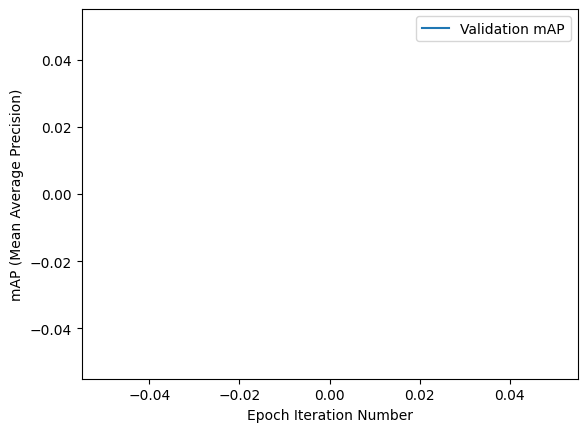

In [48]:
plt.plot(range(len(mAP_valid_list)), [x.item() for x in mAP_valid_list], label='Validation mAP')
# plt.plot(range(len(mAP_train_list)), [x.item() for x in mAP_train_list], label='Training mAP')
plt.legend()
plt.xlabel("Epoch Iteration Number")
plt.ylabel("mAP (Mean Average Precision)")

In [55]:
import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import plot_bbox_and_label

### Training Results! 
Left is the predictions by our model, the right is the labeled datapoint from out training dataset (does not include validation set datapoints)

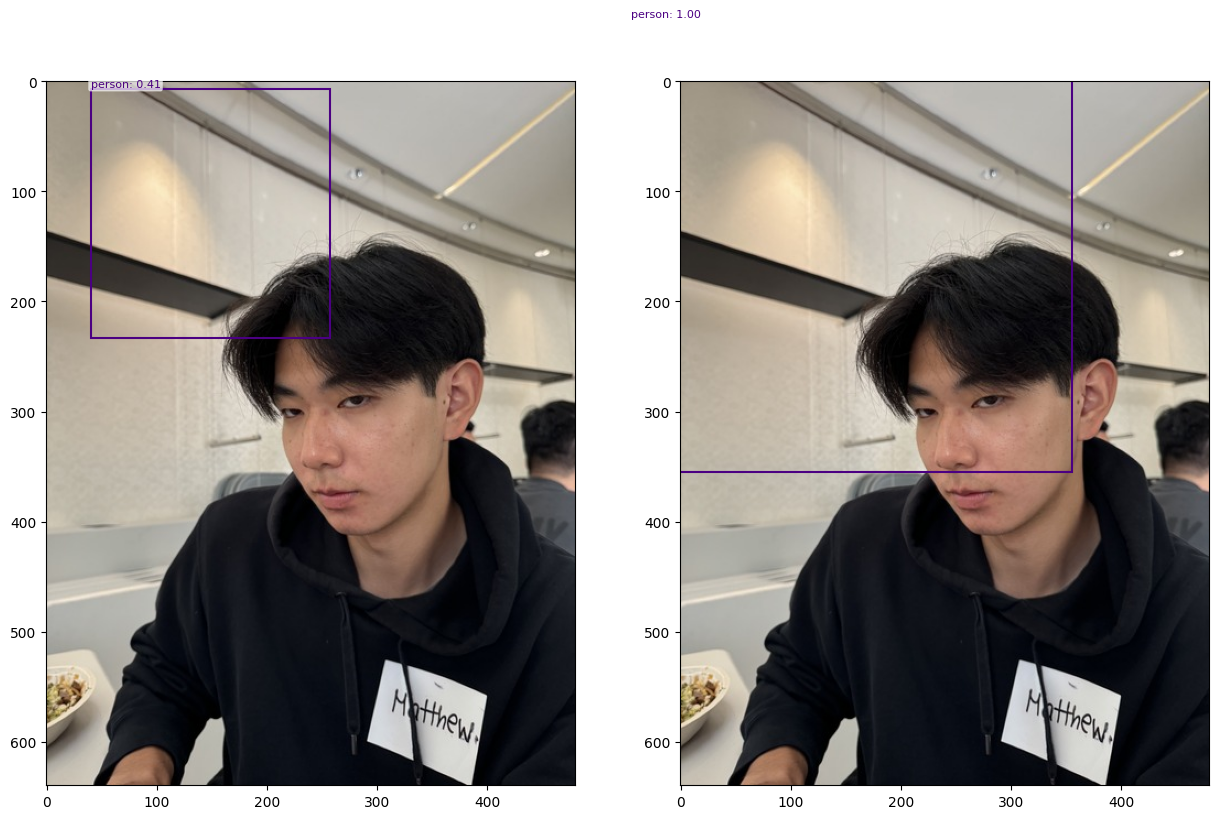

In [56]:
plot_bbox_and_label("10matthew.csv", 0, pred_boxes_train, target_boxes_train)

In [ ]:
plot_bbox_and_label("train_trimmed.csv", 5, pred_boxes_train, target_boxes_train)

In [ ]:
plot_bbox_and_label("train_trimmed.csv", 10, pred_boxes_train, target_boxes_train)

### Testing Results! 
Left is the predictions by our model, the right is the labeled test datapoint

In [ ]:
plot_bbox_and_label("test.csv", 0, pred_boxes_test, target_boxes_test)

In [ ]:
plot_bbox_and_label("test.csv", 5, pred_boxes_test, target_boxes_test)

In [ ]:
plot_bbox_and_label("test.csv", 15, pred_boxes_test, target_boxes_test)

In [ ]:
plot_bbox_and_label("test.csv", 25, pred_boxes_test, target_boxes_test)